In [2]:
from skbio import TreeNode
import pandas as pd
from Bio import SeqIO
import networkx as nx
import math
import numpy as np
import seaborn as sns

## Étape 2.1: Matcher les séquences de nos datasets avec la référence de phylogénie

In [3]:
#loaidng the sequences and the reference phylogeny

In [4]:
gg_phylogeny = TreeNode.read("../2024.09.phylogeny.asv.nwk")

In [6]:
#extracting sequences from the biom table
T2D_seqs = []
with open("FILTERED_T2D_BIOM/AGP_seqs.fa") as f:
    for l in f.readlines():
        if ">" not in l:
            T2D_seqs.append(l.strip())
noT2D_seqs = []
with open("FILTERED_noT2D_BIOM/AGP_seqs.fa") as f:
    for l in f.readlines():
        if ">" not in l:
            noT2D_seqs.append(l.strip())
                

In [7]:
len(T2D_seqs)

244

In [8]:
len(noT2D_seqs)

235

In [9]:
#are our sequences in the phylogeny ?

In [10]:
all_gg_tips = list(gg_phylogeny.tips())

In [11]:
all_gg_tip_names = [x.name for x in all_gg_tips]

In [13]:
match = 0
nomatch = 0
for i in noT2D_seqs:
    if i in all_gg_tip_names:
        match+=1
    else:
        nomatch+=1


In [14]:
nomatch

0

In [15]:
match

235

Ok, toutes nos séquences semblent être dans notre phylogénie de référence

In [16]:
overlap = set(T2D_seqs).intersection(set(noT2D_seqs))

In [17]:
len(overlap)

175

In [18]:
all_seqs = list(set(T2D_seqs + noT2D_seqs))

In [19]:
seq_dict = {}

## Étape 2.2 : aligner nos séquences
On va vouloir mesurer une distance entre les séquences. Pour faire ça, on va devoir les aligner. Puisque ce sont toutes des séquences du ribosome 16S qui est très stable, on peut les aligner avec infernal, un logiciel qui aligne après avoir été entraîné sur des séquences Rfam.

In [20]:
len(all_seqs)

304

In [ ]:

with open('T2D_all_seqs.fasta','w') as f:
    namebase = 'T2D'
    iter = 0
    for i in all_seqs:
        seq_dict["T2D_"+str(iter)]=i
        #f.write('>T2D_'+str(iter)+"\n")
        #f.write(i+"\n")

        iter+=1
    

In [ ]:
#Aligning the sequences... we can probably use infernal

In [ ]:
!cmalign -o output.txt rfam.cm T2D_all_seqs.fasta

## Étape 2.3: réduction de l'arbre
Notre arbre de référence est gigantesque. On a pas besoin de toutes ces informations-là. on va donc enlever toutes les séquences (tips) de l'arbre qui ne sont pas dans notre dataset

In [ ]:
#now that the sequences are aligned, we can shear the tree and start our computations

In [21]:
sheared_tree = gg_phylogeny.shear(all_seqs) #notre arbre spécifique à nos datasets

In [22]:
aln_dict = SeqIO.to_dict(SeqIO.parse("T2D_seqs_CMaligned_with_Rfam.sto", "stockholm")) #nos séquences spécifiques à notre dataset

In [23]:
aln_dict

{'T2D_0': SeqRecord(seq=Seq('UACGGAGGAUCCGAGCGUUAUCCGGAUUUAUUGGGUUUAAAGGGAGCGUAGGCG...GG-'), id='T2D_0', name='T2D_0', description='T2D_0', dbxrefs=[]),
 'T2D_1': SeqRecord(seq=Seq('UACGUAGGUGGCAAGCGUUGUCCGGAAUUAUUGGGCGUAAAGAGCAUGUAGGCG...AGU'), id='T2D_1', name='T2D_1', description='T2D_1', dbxrefs=[]),
 'T2D_2': SeqRecord(seq=Seq('UACGAAGGGGGCGAGCGUUGUUCGGAAUUACUGGGCGUAAAGGGUGUGUAGGCG...AG-'), id='T2D_2', name='T2D_2', description='T2D_2', dbxrefs=[]),
 'T2D_3': SeqRecord(seq=Seq('UACGUAGGGGGCGAGCGUUGUCCGGAAUUACUGGGCGUAAAGGGUGCGUAGGCG...AG-'), id='T2D_3', name='T2D_3', description='T2D_3', dbxrefs=[]),
 'T2D_4': SeqRecord(seq=Seq('UACGUAGGGUGCGAGCGUUAAUCGGAAUUACUGGGCGUAAAGCGGGCGCAGACG...CG-'), id='T2D_4', name='T2D_4', description='T2D_4', dbxrefs=[]),
 'T2D_5': SeqRecord(seq=Seq('UACGUAGGUGGCGAGCGUUGUCCGGAUUUACUGGGCGUAAAGGGAGCGUAGGCG...AG-'), id='T2D_5', name='T2D_5', description='T2D_5', dbxrefs=[]),
 'T2D_6': SeqRecord(seq=Seq('UACGUAUGGUGCAAGCGUUAUCCGGAUUUACUGGGUGUAAAGGGUGCGUAGGU

## Étape 2.4: mesures de distances entre les séquences
On va utiliser trois types de distances:
- distance feuille a feuille dans l'arbre (get_tree_dist)
- Jukes Cantor distance (get_seq_dist)
- distance réseau phylogénétique (à partir d'un réseau phylogénétique du dataset calculé par SplitsTree)

In [24]:
cophen_matrix = sheared_tree.cophenet()
def get_tree_dist(seq1,seq2,cophen_matrix):
    
    return cophen_matrix[seq1,seq2]


#autor = hboutou
def JC_distance (seq1, seq2):
    # Jukes Cantor distance formula: (-3/4)ln[1-p*(4/3)]
    p = percent_difference_of_nucleotides(seq1, seq2)
    return -0.75 * math.log(1 - (p*4/3)) if p else 0

#autor = hboutou
def percent_difference_of_nucleotides (seq1, seq2, nucleobases=set('ACGT')):
	# percentage of nucleotide difference in two sequences

	diff_count = 0 # number of nucleotide differences
	valid_nucleotides_count = 0.0 # number of valid nucleotides (value is float for computing percentage)

	for a, b in zip(seq1, seq2):
		if a in nucleobases and b in nucleobases:
			valid_nucleotides_count += 1
			if a != b: diff_count += 1
	
	return diff_count / valid_nucleotides_count if valid_nucleotides_count else 0


def get_seq_dist(seq1,seq2,aln):
    gapped_seq1 = aln[seq1]
    gapped_seq2 = aln[seq2]
    return JC_distance(gapped_seq1, gapped_seq2)

def find_node_matching_seqID(seqID, phylo_graph):
    for node in phylo_graph.nodes(data=True):
        if "label" in node[1]:
            if node[1]["label"] == seqID:
                return node[0]
    return None
    
def get_phylo_graph_dist(seq1,seq2,phylo_graph):
    node1 = find_node_matching_seqID(seq1,phylo_graph)
    node2 = find_node_matching_seqID(seq2,phylo_graph)
    path = nx.shortest_path(phylo_graph, node1, node2)
    dist = 0
    for n in range(len(path)-1):
        dist+= float(phylo_graph.get_edge_data(path[n],path[n+1])["weight"])
    return dist

In [79]:
cophen_matrix.keys()

AttributeError: 'DistanceMatrix' object has no attribute 'keys'

In [47]:
#importing the gml output obtained from SplitsTree
phylo_graph = nx.read_gml("neighbornet_txt.gml",label = 'id')

In [8]:
len(phylo_graph.nodes())

4429

In [7]:
type(phylo_graph)

networkx.classes.graph.Graph

In [15]:
print(list(phylo_graph.nodes(data=True))[5])

(6, {'label': 'T2D_236', 'x': '-12.85', 'y': '5.8072'})


In [18]:
print(list(phylo_graph.edges(data=True))[7])

(7, 3954, {'split': '21', 'weight': '0.02708494'})


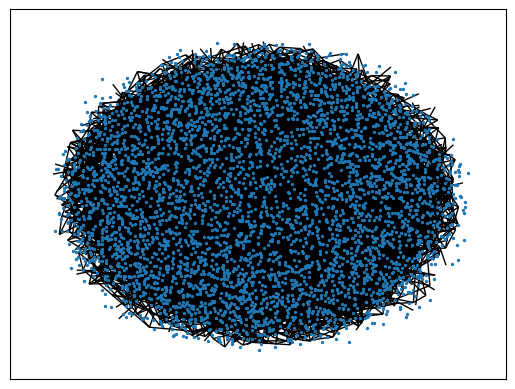

In [24]:
nodes = nx.draw_networkx_nodes(phylo_graph, pos=nx.spring_layout(phylo_graph), node_size=2)
edge_collection = nx.draw_networkx_edges(phylo_graph, pos=nx.spring_layout(phylo_graph))

In [84]:
cophen_matrix.ids

('TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGCGTGCGTAGGCTGTTTCGTAAGTCGTGTGTGAAAGGCAGGGGCTCAACCCCTGGATTGCACATGATACTGCGAGACTAGAGTAATGGAGGGGGAACCGGAATTCTCGG',
 'TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGCGTGCGTAGGCTGTTTCGTAAGTCGTGTGTGAAAGGCGCGGGCTCAACCCGCGGACGGCACATGATACTGCGAGACTAGAGTAATGGAGGGGGAACCGGAATTCTCGG',
 'TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGCGTGCGTAGGCGGTTTCGTAAGTCGTGTGTGAAAGGCGGGGGCTCAACCCCCGGACTGCACATGATACTGCGAGACTAGAGTAATGGAGGGGGAACCGGAATTCTCGG',
 'TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGCAGGCGGACCTTTAAGTCAGCTGTGAAATACGGCGGCTCAACCGTCGAACTGCAGTTGATACTGGAGGTCTTGAGTGCACACAGGGATGCTGGAATTCATGG',
 'TACGGAAGGTCCAGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGCAGGCGGACCTTTAAGTCAGCTGTGAAATACGGCGGCTCAACCGTCGAACTGCAGTTGATACTGGAGGTCTTGAGTGCACACAGGGATACTGGAATTCATGG',
 'TACGGAAGGTCCAGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCGGATTGTTAAGTCAGCGGTTAAAGGGTGTGGCTCAACCATACATTGCCGTTGAAACTGGCGATCTTGAGTGCAGACAGGGATGCCGGAATTCGTGGT',
 'TACGGAAGGTCCAGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCGGATTGTTAAGTCAG

In [69]:
get_phylo_graph_dist("T2D_1","T2D_0", phylo_graph)

0.30369007000000003

In [81]:
get_tree_dist("T2D_1","T2D_0", cophen_matrix)

MissingIDError: The ID 'At least one ID (e.g., 'T2D_0') was not found.' is not in the dissimilarity matrix.

In [71]:
#now, let's build a distance matrix for each metric 

## Étape 2.5 Calcul des trois matrices de distance

In [149]:
TreeDistMatrix = {}
SeqDistMatrix = {}
GraphDistMatrix = {}

In [150]:
for ind1, i in enumerate(list(aln_dict.keys())):
    TreeDistMatrix[i] = {}
    SeqDistMatrix[i] = {}
    GraphDistMatrix[i] = {}
    for ind2, j in enumerate(list(aln_dict.keys())):
        gg_id1 = str(seq_dict[i])
        gg_id2 = str(seq_dict[j])
        
        TreeDistMatrix[i][j] = get_tree_dist(gg_id1,gg_id2,cophen_matrix)
        SeqDistMatrix[i][j] = get_seq_dist(i,j, aln_dict)
        GraphDistMatrix[i][j] = get_phylo_graph_dist(i,j,phylo_graph)

In [137]:
MATRICES_T2D_304 = {"TreeDistMatrix":TreeDistMatrix, "SeqDistMatrix":SeqDistMatrix,"GraphDistMatrix":GraphDistMatrix}

In [138]:
import pickle
pickle.dump(MATRICES_T2D_304, open("MATRICES_T2D_304.pickle","wb"))

In [139]:
#lets make some heatmaps

In [158]:
GraphDistMatrix['T2D_1']['T2D_0']

0.30369007000000003

In [142]:
TDM = np.array([[TreeDistMatrix[i][j] for j in TreeDistMatrix.keys()] for i in TreeDistMatrix.keys()])

In [143]:
TDM[5]

array([107.970781, 419.807678, 504.705251, 248.874003, 104.299736,
         0.      , 446.183701,  99.977698, 492.347588, 462.532069,
       108.366348,   9.394109, 441.512112, 491.826548, 414.86444 ,
        97.566205, 141.504104, 447.741136, 548.336669, 503.536912,
       261.132302, 113.613258, 503.667302, 438.886729, 425.24269 ,
       460.010147, 453.177613, 153.925145, 478.228775, 523.741642,
       141.605243, 428.705006, 450.156291, 450.232302, 442.449519,
       496.37489 , 452.036834, 115.90775 , 507.118507, 487.224504,
       420.311588, 490.167197, 441.56553 , 460.070897, 446.253   ,
       446.63558 , 104.066273,  91.078738, 482.474799, 447.457796,
       383.904256, 140.134333, 105.500639, 408.385218, 412.182502,
       160.083796, 534.283894, 367.104779, 140.890774, 108.791367,
       142.332232, 429.808545, 494.132744, 106.840226, 492.885646,
       507.196429, 510.624623, 107.246479, 422.275364, 423.883365,
       536.698079, 441.79712 , 141.916441, 479.127511, 113.884

In [108]:
TDM[0]

{'T2D_0':                                                    i  \
 0  TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...   
 
                                                    j  value  
 0  TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...    0.0  ,
 'T2D_1':                                                    i  \
 0  TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...   
 1  TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...   
 2  TACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTG...   
 3  TACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTG...   
 
                                                    j       value  
 0  TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...    0.000000  
 1  TACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTG...  400.189803  
 2  TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...  400.189803  
 3  TACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTG...    0.000000  ,
 'T2D_2':                                                    i  \
 0  TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAA

In [105]:
np.shape(TDM)

(304,)

In [151]:
SDM = np.array([[SeqDistMatrix[i][j] for j in SeqDistMatrix.keys()] for i in SeqDistMatrix.keys()])

In [159]:
GDM = np.array([[GraphDistMatrix[i][j] for j in GraphDistMatrix.keys()] for i in GraphDistMatrix.keys()])

<Axes: >

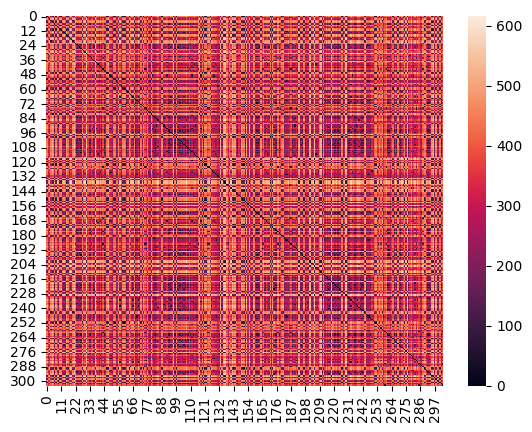

In [144]:
sns.heatmap(np.asmatrix(TDM))

<Axes: >

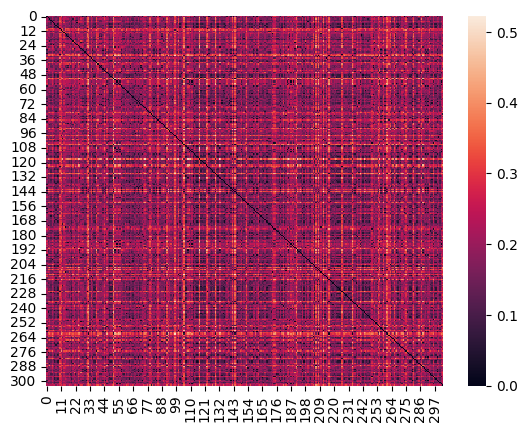

In [153]:
sns.heatmap(np.asmatrix(SDM))

<Axes: >

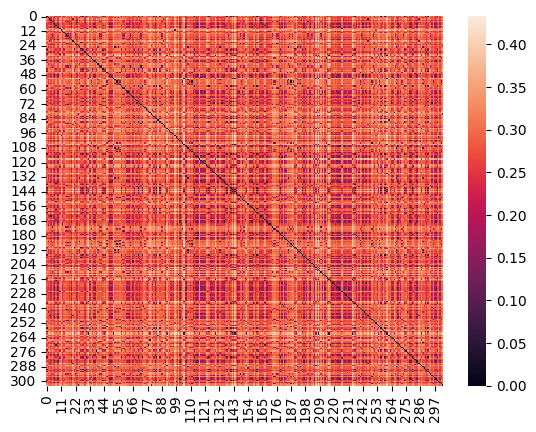

In [160]:
sns.heatmap(np.asmatrix(GDM))

## Étape 2.6: Convertir les matrices en graphes
Le problème: convertir les deux BIOM tables (diabète et non diabète) en ensembles de graphes en utilisant les distances entre les séquences.
À la fin on va avoir 6 datasets (un pour chaque type de distance pour chaque dataset)

In [ ]:
#now for each of them we can build a graph. For this information we are going to need to access the sample information.
#step 1: turn sublist of indices pairs (the ones present in the sample) from the matrix into a graph where each edge is the DM value and each node is one sequence
#step 2: assign the BIOM value to each node
#step 3: multiply all the edges by the values of their nodes
#step 4: store a vector graph -> T2D

In [163]:
#step 0: get the BIOM values associated with each sample
import dask.dataframe as ddf
import pandas as pd
import networkx as nx

In [179]:
#first, let's import the subset
df_T2D = pd.read_csv('FILTERED_T2D_BIOM/AGP.data.biom.filtered.T2D.tsv',sep='\t')

In [180]:
df_T2D.columns

Index(['#OTU ID', '10317.000098868.130064', '10317.X00162206.135989',
       '10317.000072105.128664', '10317.000027923.128668',
       '10317.000039727.130783', '10317.000054067.132132',
       '10317.X00174994.135985', '10317.000082728.128668',
       '10317.000110455.134192',
       ...
       '10317.X00214215.146211', '10317.000098998.129155',
       '10317.000085142.127418', '10317.000074283.130092',
       '10317.000110058.132367', '10317.X00166568.135998',
       '10317.000149660.135998', '10317.000082547.130092',
       '10317.000107382.132367', '10317.000108704.132367'],
      dtype='object', length=367)

À toi de jouer!